In [1]:
import sys
import json
import warnings

import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

sys.path.append('../..')
from matplotlib.patches import Rectangle
from matplotlib.ticker import FuncFormatter
from sklearn.metrics import classification_report
from matplotlib.colors import LinearSegmentedColormap
from utils import UnimapResult, set_plot_theme, generate_positions
set_plot_theme()
warnings.filterwarnings('ignore')

/home/hht/.conda/envs/unimap1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### SUP13

In [2]:
s_data = sc.read_h5ad('../../data/cross_species/human.h5ad')
t_data_mf = sc.read_h5ad('../../data/cross_species/macaqueF.h5ad')
t_data_mm = sc.read_h5ad('../../data/cross_species/macaqueM.h5ad')
t_data_mouse = sc.read_h5ad('../../data/cross_species/mouse.h5ad')
t_data = sc.concat([t_data_mf, t_data_mm, t_data_mouse], join='outer')

s_data.obs['domain'] = 'source'
t_data.obs['domain'] = 'target'
raw_data = sc.concat([s_data, t_data], join='outer')
sc.tl.pca(raw_data, svd_solver='arpack')
sc.pp.neighbors(raw_data, n_neighbors=10, n_pcs=40)
sc.tl.umap(raw_data)

result = UnimapResult('cross_species', f'unimap/2023', root_dir='../../results', detailed=False)

In [3]:
color_dict = json.load(open('../../color_dict.json'))
batch_c = color_dict["4_sp_batch"]
ct_c = color_dict["4_sp_ct"]

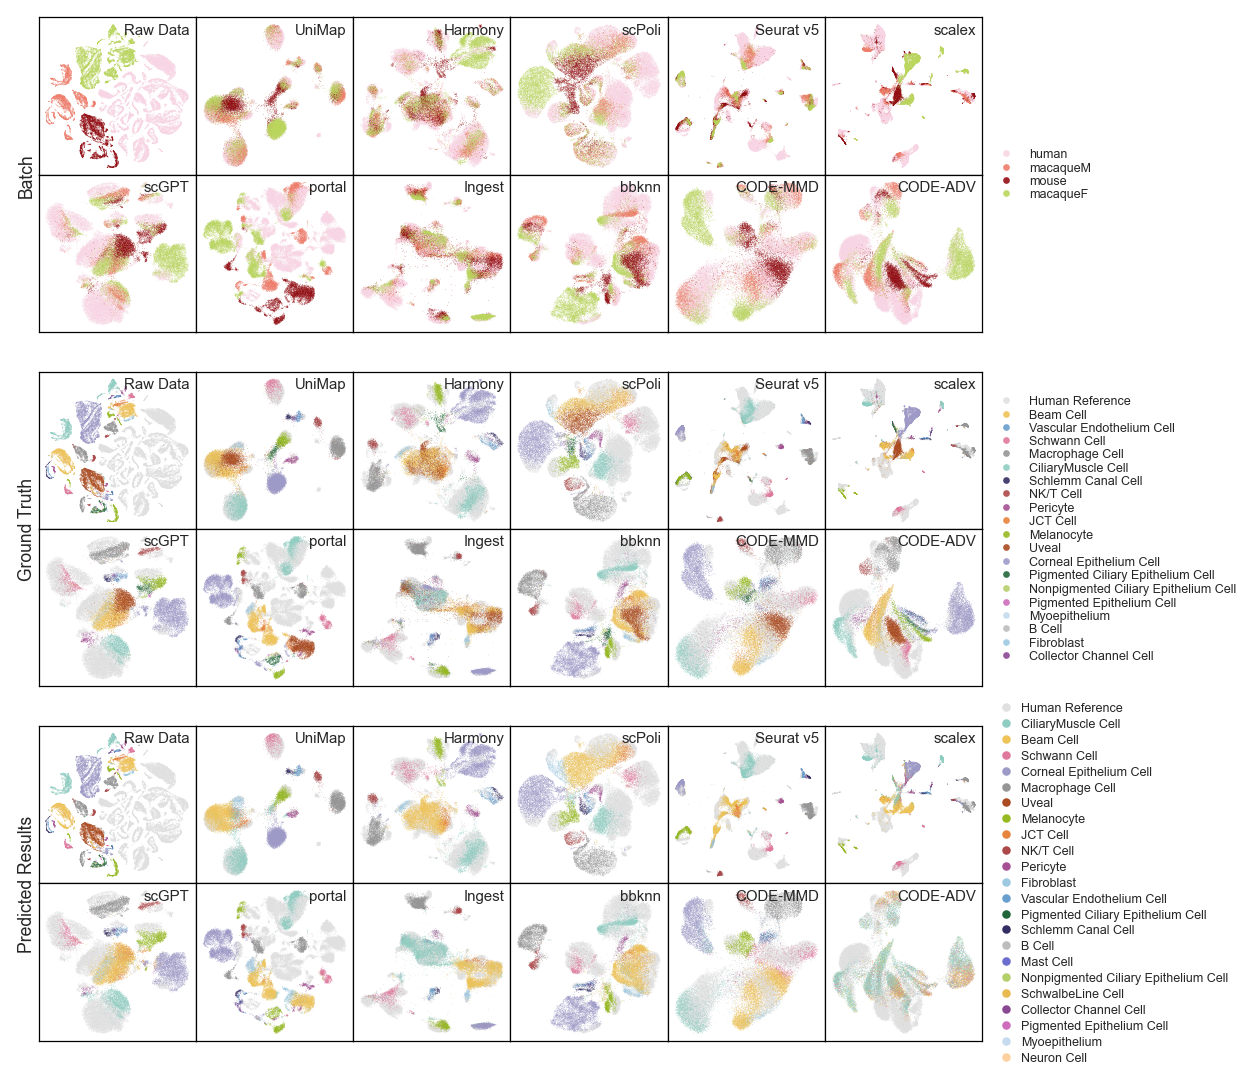

In [4]:
fig, axs = plt.subplots(figsize=(185 / 25.4, 250 / 25.4))
axs.remove()


models = ['raw_data', 'unimap', 'harmony', 'scpoli', 'seurat',  'scalex', 'scgpt', 'portal', 'ingest', 'bbknn', 'code_mmd', 'code_adv']  # 
models_name =  ['Raw Data', 'UniMap', 'Harmony', 'scPoli', 'Seurat v5', 'scalex', 'scGPT', 'portal', 'Ingest', 'bbknn', 'CODE-MMD', 'CODE-ADV']  # 

position1 = generate_positions(w=0.12, h=0.12 / (250/185), l=0.02, b=0.8)
position2 = generate_positions(w=0.12, h=0.12 / (250/185), l=0.02, b=0.6)
position3 = generate_positions(w=0.12, h=0.12 / (250/185), l=0.02, b=0.4)


for idx, model in enumerate(models):
    model_name = models_name[idx]
    if model == 'raw_data':
        umap1 = raw_data.obsm['X_umap'][:, 0]
        umap2 = raw_data.obsm['X_umap'][:, 1]

        batch_labels = list(raw_data.obs['batch'])
        ref_labels = ['Human Reference'] * sum(raw_data.obs['domain']  ==  'source')
        ct_labels = ref_labels + list(raw_data[raw_data.obs.domain == 'target'].obs.celltype)
        pd_ct_labels = ct_labels
    else:
        result = UnimapResult('cross_species', f'{model}/2023', root_dir='../../results', detailed=False)
        umap1 = result.st_umap_result['umap1']
        umap2 = result.st_umap_result['umap2']

        batch_labels = list(result.st_result.batch)
        ref_labels = ['Human Reference'] * len(result.s_result['domain'])
        ct_labels = ref_labels + list(result.t_result.celltype)
        pd_ct_labels = ref_labels + list(result.t_result.pred_celltype)
    

    ax1 = fig.add_axes(position1[idx])
    ax2 = fig.add_axes(position2[idx])
    ax3 = fig.add_axes(position3[idx])
    
    s = 0.05
    p1 = sns.scatterplot(x=umap1, y=umap2, alpha=0.9, s=s, hue=batch_labels, edgecolor='none', palette=batch_c, ax=ax1, rasterized=True)
    p2 = sns.scatterplot(x=umap1, y=umap2, alpha=0.9, s=s, hue=ct_labels, edgecolor='none', palette=ct_c, ax=ax2, rasterized=True)
    p3 = sns.scatterplot(x=umap1, y=umap2, alpha=0.9, s=s, hue=pd_ct_labels, edgecolor='none', palette=ct_c, ax=ax3, rasterized=True)
    result.remove_ticks(p1, remove_legend=True)
    result.remove_ticks(p2, remove_legend=True)
    result.remove_ticks(p3, remove_legend=True)
    p1yl = p1.set_ylabel('' if idx != 0 else 'Batch',             fontsize=7, labelpad=1)
    p2yl = p2.set_ylabel('' if idx != 0 else 'Ground Truth',      fontsize=7, labelpad=1)
    p3yl = p3.set_ylabel('' if idx != 0 else 'Predicted Results', fontsize=7, labelpad=1)
    p1yl.set_position((0, 0.0))
    p2yl.set_position((0, 0.0))
    p3yl.set_position((0, 0.0))
    p1.text(0.96, (0.92), model_name, ha='right', va='center', transform=p1.transAxes, fontsize=6)
    p2.text(0.96, (0.92), model_name, ha='right', va='center', transform=p2.transAxes, fontsize=6)
    p3.text(0.96, (0.92), model_name, ha='right', va='center', transform=p3.transAxes, fontsize=6)

    if idx == len(models) - 1:
        p1.legend(loc='center left', bbox_to_anchor=(1, 1.0), frameon=False, markerscale=12, fontsize=5, labelspacing=0.1)
        p2.legend(loc='center left', bbox_to_anchor=(1, 1.0), frameon=False, markerscale=12, fontsize=5, labelspacing=0.1)
        # p3.legend(loc='center left', bbox_to_anchor=(1, 1.0), frameon=False, markerscale=12, fontsize=5, labelspacing=0.1)
        # handles, labels = p1.get_legend_handles_labels()
        # custom_handles = [mlines.Line2D([], [], color=color, marker='o', linestyle='None', markersize=0.2, label=label) for label, color in batch_c.items()]
        # p1.legend(handles=custom_handles, loc='center left', bbox_to_anchor=(1, 1), frameon=False, markerscale=12, fontsize=5, labelspacing=0.3, handletextpad=0.2)

        # handles, labels = p2.get_legend_handles_labels()
        # custom_handles = [mlines.Line2D([], [], color=color, marker='o', linestyle='None', markersize=0.2, label=label) for label, color in ct_c.items()]
        # p2.legend(handles=custom_handles, loc='center left', bbox_to_anchor=(1, 1), frameon=False, markerscale=12, fontsize=5, labelspacing=0.3, handletextpad=0.2)
        
        handles, labels = p3.get_legend_handles_labels()
        custom_handles = [mlines.Line2D([], [], color=color, marker='o', linestyle='None', markersize=0.2, label=label) for label, color in ct_c.items()]
        p3.legend(handles=custom_handles, loc='center left', bbox_to_anchor=(1, 1), frameon=False, markerscale=12, fontsize=5, labelspacing=0.3, handletextpad=0.2)
    # if idx == 0:
    #     p1yl = p1.set_ylabel('Batch' if idx == 0 else '', fontsize=7, labelpad=1)
    #     p1yl.set_position((0, 0.0))

    #     p2yl = p2.set_ylabel('Ground Truth' if idx == 0 else '', fontsize=7, labelpad=1)
    #     p2yl.set_position((0, 0.0))

    #     p3yl = p3.set_ylabel('Predicted Results' if idx == 0 else '', fontsize=7, labelpad=1)
    #     p3yl.set_position((0, 0.0))
fig.savefig('../figs/supplementary fig13.pdf', dpi=720)
fig.savefig('../sup_figs/sup13.png', dpi=720)

### SUP14

In [5]:
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#f4f3f8', '#827fbb'])
models = ['unimap', 'harmony', 'scpoli', 'seurat',  'scalex', 'scgpt', 'portal', 'ingest', 'bbknn', 'code_mmd', 'code_adv']
l, b, w, h = 0.04, 0.75, 0.25, 0.25 / (250/185)
positions = [[0.19, 0.75, w, h], [0.46, 0.75, w, h], [0.73, 0.75, w, h],
             [0.19, 0.58, w, h], [0.46, 0.58, w, h], [0.73, 0.58, w, h],
             [0.19, 0.41, w, h], [0.46, 0.41, w, h], [0.73, 0.41, w, h],
             [0.19, 0.24, w, h], [0.46, 0.24, w, h], [0.73, 0.24, w, h],]

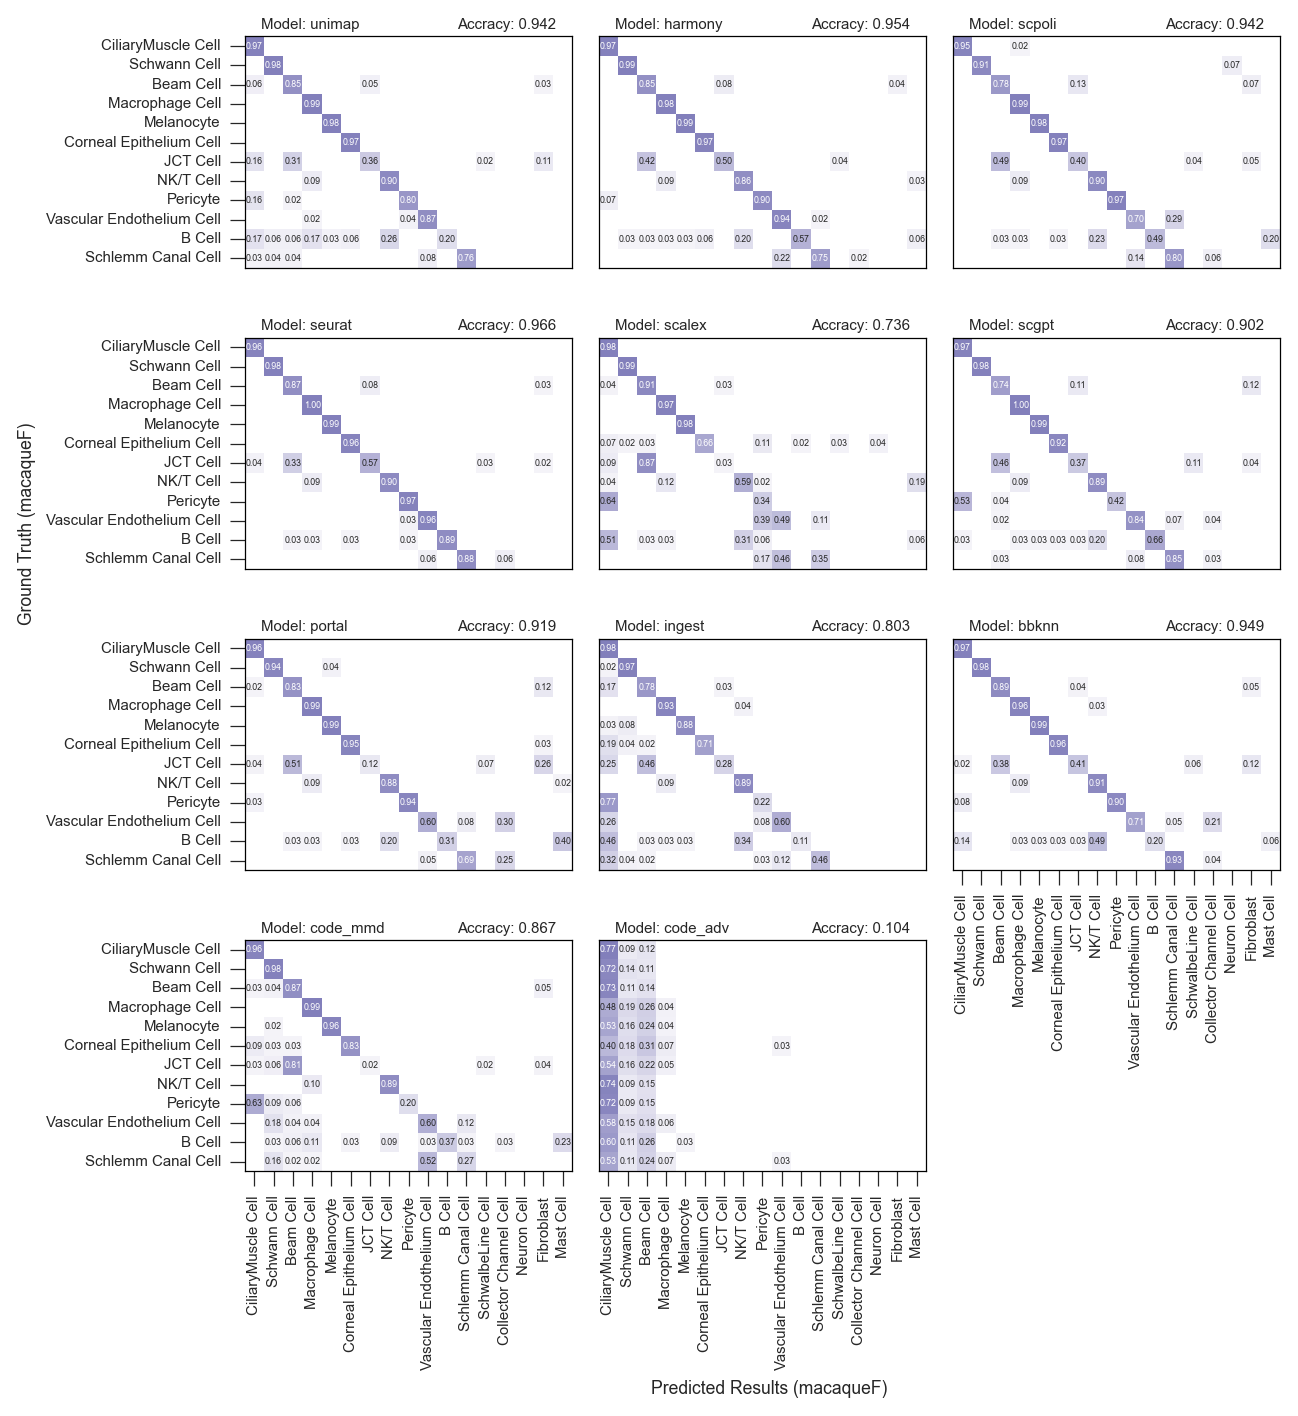

In [6]:
fig, axs = plt.subplots(figsize=(185 / 25.4, 250 / 25.4))
axs.remove()
ct = ['CiliaryMuscle Cell', 'Schwann Cell', 'Beam Cell', 'Macrophage Cell', 'Melanocyte', 'Corneal Epithelium Cell', 'JCT Cell', 'NK/T Cell', 'Pericyte', 'Vascular Endothelium Cell', 'B Cell', 'Schlemm Canal Cell']
pd_ct = ['CiliaryMuscle Cell', 'Schwann Cell', 'Beam Cell', 'Macrophage Cell', 'Melanocyte', 'Corneal Epithelium Cell', 'JCT Cell',  'NK/T Cell', 'Pericyte', 'Vascular Endothelium Cell', 'B Cell', 'Schlemm Canal Cell',
       'SchwalbeLine Cell', 'Collector Channel Cell', 'Neuron Cell', 'Fibroblast', 'Mast Cell',]

species = 'macaqueF'


for idx, model in enumerate(models):
    result = UnimapResult('cross_species', f'{model}/2023', root_dir='../../results', detailed=False)
    t_result = result.t_result[result.t_result['batch'].isin([species])]
    
    t_result_inref = t_result[~t_result['celltype'].isin(set(ct) - set(pd_ct))]
    acc = (t_result_inref['celltype'] == t_result_inref['pred_celltype']).mean(). __round__(3)

    cm = result.get_cm(percentage_direction=0, ct_labels=ct, pd_ct_labels=pd_ct)
    ax = sns.heatmap(cm, annot=True, cmap=custom_cmap, annot_kws={'size': 3.5}, fmt='.2f', cbar=False, square=True, mask=cm < 0.02, ax=fig.add_axes(positions[idx]), xticklabels=pd_ct, yticklabels=ct)

    ax.tick_params(bottom=False, top=False, left=False, right=False)
    result.remove_spines(ax, sp_v=True, remove_legend=False)

    ax.text(0.05, 1.05, f'Model: {model}', ha='left', va='center', transform=ax.transAxes, fontdict={'fontsize': 6})
    ax.text(0.95, 1.05, f'Accracy: {acc}', ha='right', va='center', transform=ax.transAxes, fontdict={'fontsize': 6})

    if (idx % 3) == 0:
        ax.set_yticklabels(ct, rotation=0, fontsize=6)
        ax.tick_params(bottom=False, top=False, left=True, right=False, width=0.5)
    else:
        ax.set_yticklabels([])

    if idx > 7:
        ax.tick_params(bottom=True, width=0.5)
        ax.set_xticklabels(pd_ct, rotation=90, ha='center', fontsize=6)
    else:
        ax.set_xticklabels([])

    if idx == 9:
        xl = ax.set_xlabel(f'Predicted Results ({species})', fontsize=7)
        xl.set_position((1.6, 0.0))
        yl = ax.set_ylabel(f'Ground Truth ({species})', fontsize=7)
        yl.set_position((0, 2.8))

# fig.savefig('../figs/supplementary fig14a.pdf', dpi=720)
# fig.savefig('../sup_figs/sup14a.png', dpi=720)

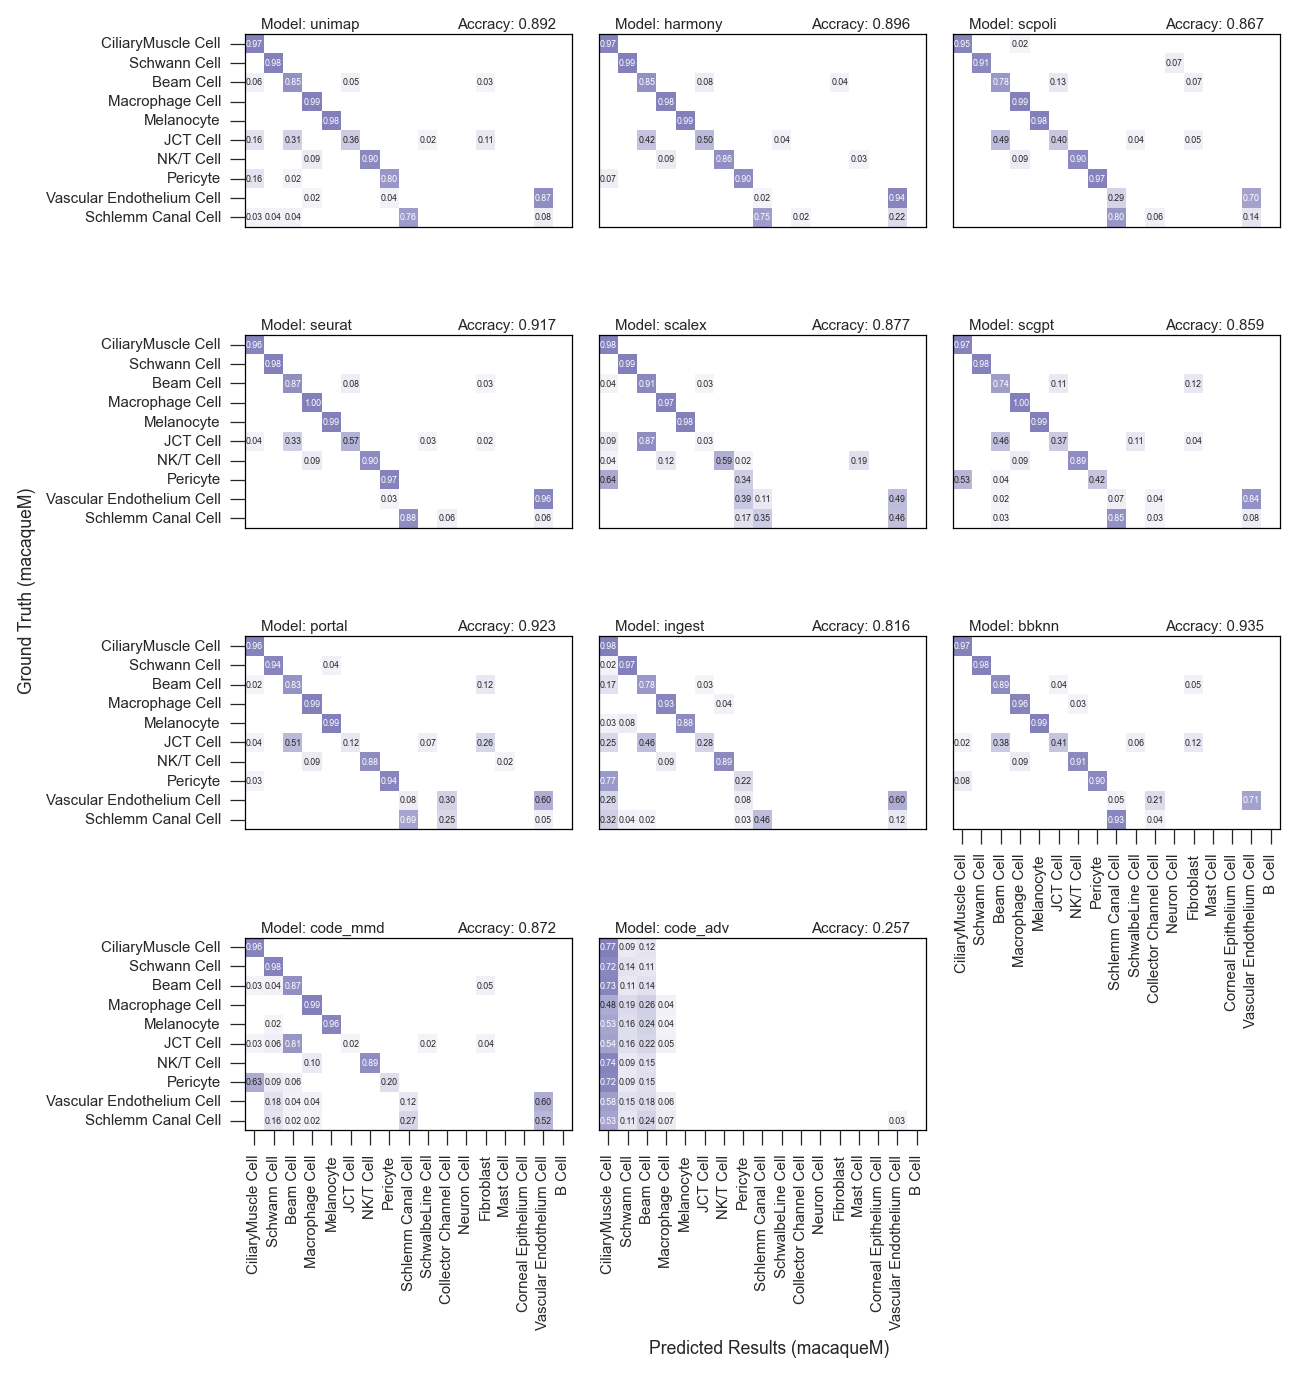

In [7]:
fig, axs = plt.subplots(figsize=(185 / 25.4, 250 / 25.4))
axs.remove()
ct = ['CiliaryMuscle Cell', 'Schwann Cell', 'Beam Cell', 'Macrophage Cell', 'Melanocyte', 'JCT Cell', 'NK/T Cell', 'Pericyte', 'Vascular Endothelium Cell', 'Schlemm Canal Cell',
  ]

pd_ct = ['CiliaryMuscle Cell', 'Schwann Cell', 'Beam Cell', 'Macrophage Cell', 'Melanocyte', 'JCT Cell',  'NK/T Cell', 'Pericyte', 'Schlemm Canal Cell',
       'SchwalbeLine Cell', 'Collector Channel Cell', 'Neuron Cell', 'Fibroblast', 'Mast Cell', 'Corneal Epithelium Cell', 'Vascular Endothelium Cell', 'B Cell', ]

species = 'macaqueM'


for idx, model in enumerate(models):
    result = UnimapResult('cross_species', f'{model}/2023', root_dir='../../results', detailed=False)
    t_result = result.t_result[result.t_result['batch'].isin([species])]
    
    t_result_inref = t_result[~t_result['celltype'].isin(set(ct) - set(pd_ct))]
    acc = (t_result_inref['celltype'] == t_result_inref['pred_celltype']).mean(). __round__(3)

    cm = result.get_cm(percentage_direction=0, ct_labels=ct, pd_ct_labels=pd_ct)
    ax = sns.heatmap(cm, annot=True, cmap=custom_cmap, annot_kws={'size': 3.5}, fmt='.2f', cbar=False, square=True, mask=cm < 0.02, ax=fig.add_axes(positions[idx]), xticklabels=pd_ct, yticklabels=ct)

    ax.tick_params(bottom=False, top=False, left=False, right=False)
    result.remove_spines(ax, sp_v=True, remove_legend=False)

    ax.text(0.05, 1.05, f'Model: {model}', ha='left', va='center', transform=ax.transAxes, fontdict={'fontsize': 6})
    ax.text(0.95, 1.05, f'Accracy: {acc}', ha='right', va='center', transform=ax.transAxes, fontdict={'fontsize': 6})

    if (idx % 3) == 0:
        ax.set_yticklabels(ct, rotation=0, fontsize=6)
        ax.tick_params(bottom=False, top=False, left=True, right=False, width=0.5)
    else:
        ax.set_yticklabels([])

    if idx > 7:
        ax.tick_params(bottom=True, width=0.5)
        ax.set_xticklabels(pd_ct, rotation=90, ha='center', fontsize=6)
    else:
        ax.set_xticklabels([])

    if idx == 9:
        xl = ax.set_xlabel(f'Predicted Results ({species})', fontsize=7)
        xl.set_position((1.6, 0.0))
        yl = ax.set_ylabel(f'Ground Truth ({species})', fontsize=7)
        yl.set_position((0, 2.8))

# fig.savefig('../figs/supplementary fig14b.pdf', dpi=720)
# fig.savefig('../sup_figs/sup14b.png', dpi=720)

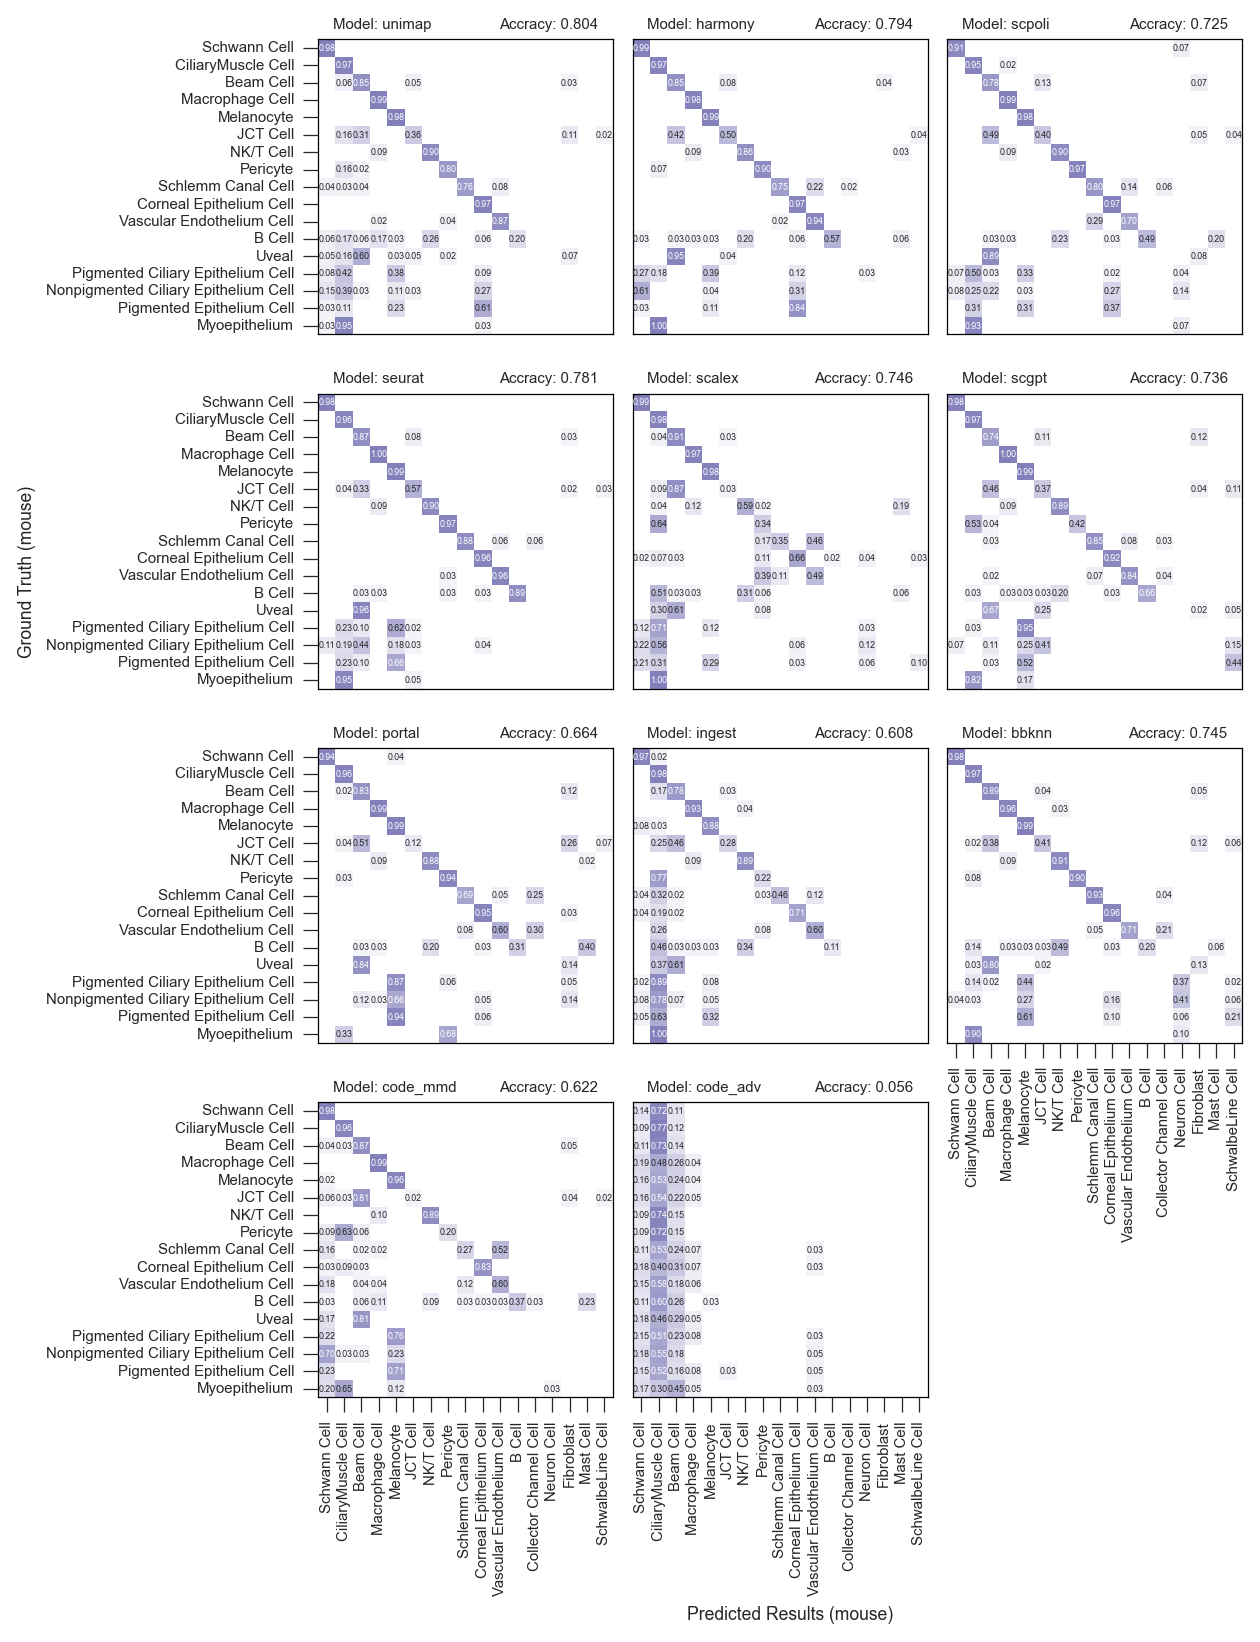

In [8]:
fig, axs = plt.subplots(figsize=(185 / 25.4, 250 / 25.4))
axs.remove()

positions = [[0.24, 0.75, w*0.9, h*0.9], [0.48, 0.75, w*0.9, h*0.9], [0.72, 0.75, w*0.9, h*0.9],
             [0.24, 0.55, w*0.9, h*0.9], [0.48, 0.55, w*0.9, h*0.9], [0.72, 0.55, w*0.9, h*0.9],
             [0.24, 0.35, w*0.9, h*0.9], [0.48, 0.35, w*0.9, h*0.9], [0.72, 0.35, w*0.9, h*0.9],
             [0.24, 0.15, w*0.9, h*0.9], [0.48, 0.15, w*0.9, h*0.9], [0.72, 0.15, w*0.9, h*0.9],]
ct = ['Schwann Cell', 'CiliaryMuscle Cell', 'Beam Cell', 'Macrophage Cell', 'Melanocyte', 'JCT Cell', 'NK/T Cell', 'Pericyte', 'Schlemm Canal Cell', 'Corneal Epithelium Cell', 'Vascular Endothelium Cell', 'B Cell', 
    'Uveal', 'Pigmented Ciliary Epithelium Cell', 'Nonpigmented Ciliary Epithelium Cell', 'Pigmented Epithelium Cell', 'Myoepithelium', ]

pd_ct = ['Schwann Cell', 'CiliaryMuscle Cell', 'Beam Cell', 'Macrophage Cell', 'Melanocyte', 'JCT Cell',  'NK/T Cell', 'Pericyte', 'Schlemm Canal Cell', 'Corneal Epithelium Cell', 'Vascular Endothelium Cell', 'B Cell',
       'Collector Channel Cell', 'Neuron Cell', 'Fibroblast', 'Mast Cell', 'SchwalbeLine Cell', ]

species = 'mouse'


for idx, model in enumerate(models):
    result = UnimapResult('cross_species', f'{model}/2023', root_dir='../../results', detailed=False)
    t_result = result.t_result[result.t_result['batch'].isin([species])]
    
    t_result_inref = t_result[~t_result['celltype'].isin(set(ct) - set(pd_ct))]
    acc = (t_result_inref['celltype'] == t_result_inref['pred_celltype']).mean(). __round__(3)

    cm = result.get_cm(percentage_direction=0, ct_labels=ct, pd_ct_labels=pd_ct)
    ax = sns.heatmap(cm, annot=True, cmap=custom_cmap, annot_kws={'size': 3.5}, fmt='.2f', cbar=False, square=True, mask=cm < 0.02, ax=fig.add_axes(positions[idx]), xticklabels=pd_ct, yticklabels=ct)

    ax.tick_params(bottom=False, top=False, left=False, right=False)
    result.remove_spines(ax, sp_v=True, remove_legend=False)

    ax.text(0.05, 1.05, f'Model: {model}', ha='left', va='center', transform=ax.transAxes, fontdict={'fontsize': 6})
    ax.text(0.95, 1.05, f'Accracy: {acc}', ha='right', va='center', transform=ax.transAxes, fontdict={'fontsize': 6})

    if (idx % 3) == 0:
        ax.set_yticklabels(ct, rotation=0, fontsize=6)
        ax.tick_params(bottom=False, top=False, left=True, right=False, width=0.5)
    else:
        ax.set_yticklabels([])

    if idx > 7:
        ax.tick_params(bottom=True, width=0.5)
        ax.set_xticklabels(pd_ct, rotation=90, ha='center', fontsize=6)
    else:
        ax.set_xticklabels([])

    if idx == 9:
        xl = ax.set_xlabel(f'Predicted Results ({species})', fontsize=7)
        xl.set_position((1.6, 0.0))
        yl = ax.set_ylabel(f'Ground Truth ({species})', fontsize=7)
        yl.set_position((0, 2.8))

# fig.savefig('../figs/supplementary fig14c.pdf', dpi=720)
# fig.savefig('../sup_figs/sup14c.png', dpi=720)

### SUP15

In [9]:
result = UnimapResult('cross_species', 'unimap/2023', root_dir='../../results', detailed=False)
human_index = result.st_result[result.st_result.batch == 'human'].index
mf_index = result.st_result[result.st_result.batch == 'macaqueF'].index
mm_index = result.st_result[result.st_result.batch == 'macaqueM'].index
mouse_index = result.st_result[result.st_result.batch == 'mouse'].index

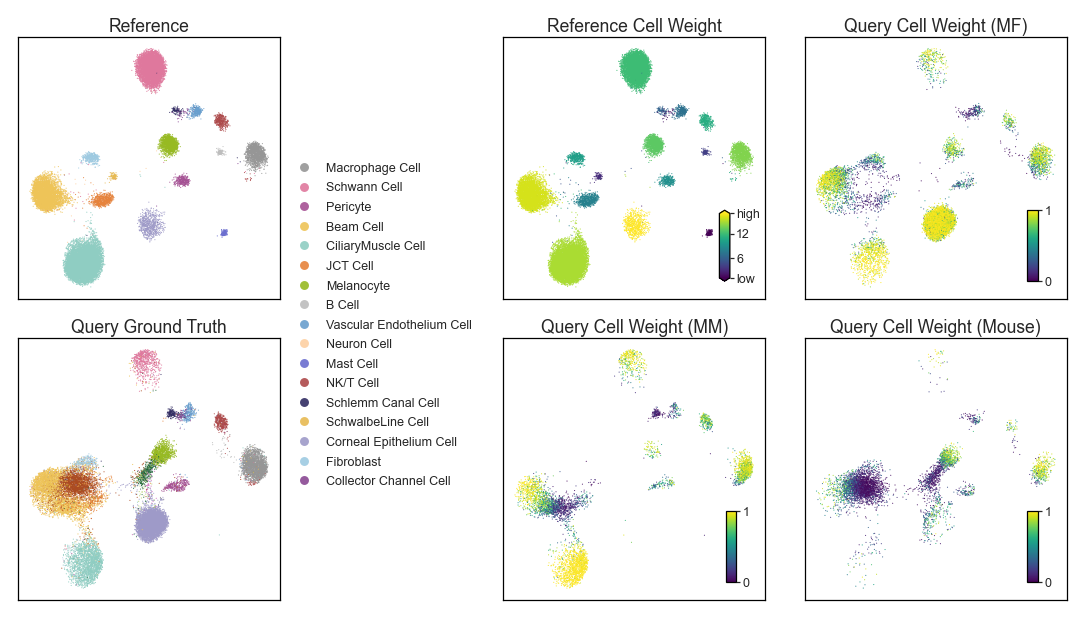

In [10]:
fig, axs = plt.subplots(figsize=(185 / 25.4, 250 / 25.4))
axs.remove()
w, h = 0.20, 0.20 / (250/185)
position1 = [[0.1, 0.75, w, h], [0.47, 0.75, w, h], [0.70, 0.75, w, h],
             [0.1, 0.58, w, h], [0.47, 0.58, w, h], [0.70, 0.58, w, h], ]

ax0 = fig.add_axes(position1[0])
ax1 = fig.add_axes(position1[1])
ax2 = fig.add_axes(position1[2])
ax3 = fig.add_axes(position1[3])
ax4 = fig.add_axes(position1[4])
ax5 = fig.add_axes(position1[5])


p0 = sns.scatterplot(x=result.s_umap_result.loc[:, 'umap1'],
                     y=result.s_umap_result.loc[:, 'umap2'],
                     alpha=0.9, s=0.2,
                     hue=result.s_result.loc[:, 'celltype'],
                     edgecolor='none',
                     palette=ct_c,
                     ax=ax0, rasterized=True)
p1 = sns.scatterplot(x=result.st_umap_result.loc[human_index, 'umap1'],
                     y=result.st_umap_result.loc[human_index, 'umap2'],
                     alpha=0.9, s=0.2,
                     hue=result.st_result.loc[human_index, 'pred_celltype_prob'].rank(method='dense', ascending=False),
                     edgecolor='none',
                     palette='viridis_r',
                     ax=ax1, rasterized=True)
p2 = sns.scatterplot(x=result.st_umap_result.loc[mf_index, 'umap1'],
                     y=result.st_umap_result.loc[mf_index, 'umap2'],
                     alpha=0.9, s=0.2,
                     hue=result.st_result.loc[mf_index, 'pred_cell_prob'],
                     edgecolor='none',
                     palette='viridis',
                     ax=ax2, rasterized=True)

p3 = sns.scatterplot(x=result.t_umap_result.loc[:, 'umap1'],
                     y=result.t_umap_result.loc[:, 'umap2'],
                     alpha=0.9, s=0.2,
                     hue=result.t_result.loc[:, 'celltype'],
                     edgecolor='none',
                     palette=ct_c,
                     ax=ax3, rasterized=True)
p4 = sns.scatterplot(x=result.st_umap_result.loc[mm_index, 'umap1'],
                     y=result.st_umap_result.loc[mm_index, 'umap2'],
                     alpha=0.9, s=0.2,
                     hue=result.st_result.loc[mm_index, 'pred_cell_prob'],
                     edgecolor='none',
                     palette='viridis',
                     ax=ax4, rasterized=True)
p5 = sns.scatterplot(x=result.st_umap_result.loc[mouse_index, 'umap1'],
                     y=result.st_umap_result.loc[mouse_index, 'umap2'],
                     alpha=0.9, s=0.2,
                     hue=result.st_result.loc[mouse_index, 'pred_cell_prob'],
                     edgecolor='none',
                     palette='viridis',
                     ax=ax5, rasterized=True)
position1 = [[0.1, 0.75, w, h], [0.47, 0.75, w, h], [0.70, 0.75, w, h],
             [0.1, 0.58, w, h], [0.47, 0.58, w, h], [0.70, 0.58, w, h], ]
bar_position = [[0.47+0.165, 0.75+0.01, 0.008, 0.20/5], [0.7+0.17, 0.75+0.01, 0.008, 0.20/5],
                [0.47+0.170, 0.58+0.01, 0.008, 0.20/5], [0.7+0.17, 0.58+0.01, 0.008, 0.20/5],]

norm = plt.Normalize(vmin=1, vmax=17)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
cbar = fig.colorbar(sm, cax=fig.add_axes(bar_position[0]), extend='both')
cbar.set_ticks([1, 6, 12, 17])
cbar.set_ticklabels(['low', '6', '12','high'])
cbar.ax.tick_params(labelsize=5, length=1.5, pad=1, width=0.5)

norm2 = plt.Normalize(vmin=0, vmax=1)
sm2 = plt.cm.ScalarMappable(cmap='viridis', norm=norm2)
cbar2 = fig.colorbar(sm2, cax=fig.add_axes(bar_position[1]))
cbar2.set_ticks([0, 1])
cbar2.set_ticklabels(['0', '1'])
cbar2.ax.tick_params(labelsize=5, length=1.5, pad=1, width=0.5)

cbar2 = fig.colorbar(sm2, cax=fig.add_axes(bar_position[2]))
cbar2.set_ticks([0, 1])
cbar2.set_ticklabels(['0', '1'])
cbar2.ax.tick_params(labelsize=5, length=1.5, pad=1, width=0.5)

cbar2 = fig.colorbar(sm2, cax=fig.add_axes(bar_position[3]))
cbar2.set_ticks([0, 1])
cbar2.set_ticklabels(['0', '1'])
cbar2.ax.tick_params(labelsize=5, length=1.5, pad=1, width=0.5)

result.remove_ticks(p0)
result.remove_ticks(p1, remove_legend=True)
result.remove_ticks(p2, remove_legend=True)
result.remove_ticks(p3, remove_legend=True)
result.remove_ticks(p4, remove_legend=True)
result.remove_ticks(p5, remove_legend=True)
# p0.legend_.remove()
p0.legend(loc='center left', bbox_to_anchor=(1, -0.1), frameon=False, markerscale=8, fontsize=5, labelspacing=0.6)

p0.set_title('Reference', fontsize=7, pad=2)
p1.set_title('Reference Cell Weight', fontsize=7, pad=2)
p2.set_title('Query Cell Weight (MF)', fontsize=7, pad=2)
p3.set_title('Query Ground Truth', fontsize=7, pad=2)
p4.set_title('Query Cell Weight (MM)', fontsize=7, pad=2)
t = p5.set_title('Query Cell Weight (Mouse)', fontsize=7, pad=2)
# fig.savefig('../figs/supplementary fig15.pdf', dpi=720)
# fig.savefig('../sup_figs/sup15.png', dpi=720)

### SUP16

In [11]:
def cal_thres_ac(t_result):
    num_cells = t_result.shape[0]
    threshold_df = pd.DataFrame(columns=['threshold', 'percentage'])
    for i in range(0, 96):
        threshold = i / 100
        t_result_temp = t_result[t_result['pred_cell_prob'] > threshold]
        t_ct, pd_ct = t_result_temp['celltype'].to_list(), t_result_temp['pred_celltype'].to_list()
        cls_rpt_d = classification_report(t_ct, pd_ct, digits=4, zero_division=0, output_dict=True)
        f1 = cls_rpt_d['weighted avg']['f1-score']
        acc = cls_rpt_d['accuracy']
        pre = cls_rpt_d['weighted avg']['precision']
        recall = cls_rpt_d['weighted avg']['recall']
        # nmi = normalized_mutual_info_score(t_ct, pd_ct)
        # ari = adjusted_rand_score(t_ct, pd_ct)
        percentage = t_result_temp.shape[0] / num_cells
        eval_result = pd.DataFrame({'threshold': threshold, 'acc': acc, 'f1': f1,  'percentage': percentage}, index=['unimap'])  # 'precision': pre, 'recall': recall,
        threshold_df = pd.concat([threshold_df, eval_result], axis=0)
    return threshold_df

result = UnimapResult('cross_species', 'unimap/2023', root_dir='../../results', detailed=False)
all_sp_thres = cal_thres_ac(result.t_result)
mf_thres = cal_thres_ac(result.t_result[result.t_result['batch'] == 'macaqueF'])
mm_thres = cal_thres_ac(result.t_result[result.t_result['batch'] == 'macaqueM'])
mouse_thres = cal_thres_ac(result.t_result[result.t_result['batch'] == 'mouse'])

In [12]:
def mode_ax(ax, title='All species', xlabel='Cell Weight Threshold', ylabel='Value'):
    ax.set_title(title, fontsize=6)
    ax.set_xlabel(xlabel, fontsize=6)
    ax.set_ylabel(ylabel, fontsize=6)
    ax.set_xlim(-0.1, 1.1)
    ax.set_xticks([0.0, 0.25, 0.50, 0.75, 1.0])
    # ax.set_ylim(-0.1, 1.1)
    # ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.tick_params(axis='y', labelsize=5, pad=1)
    ax.set_xticklabels(['0.00', '0.25', '0.50', '0.75', '1.00'], fontsize=5)
    ax.tick_params(bottom=True, left=True, width=0.5, length=2)

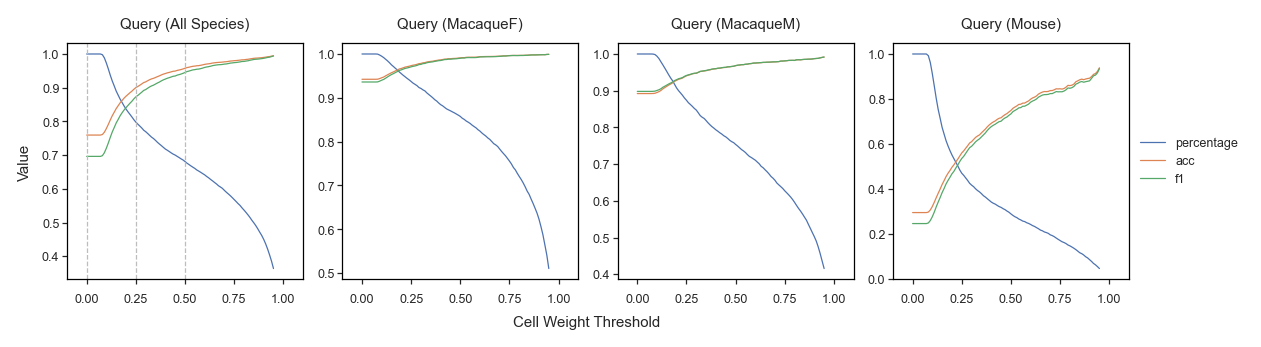

In [13]:
fig, axs = plt.subplots(figsize=(185 / 25.4, 250 / 25.4))
axs.remove()
position2 = [[0.03, 0.70, 0.18, 0.18 / (250/185)], [0.24, 0.70, 0.18, 0.18 / (250/185)],
             [0.45, 0.70, 0.18, 0.18 / (250/185)], [0.66, 0.70, 0.18, 0.18 / (250/185)]]

lp0 = sns.lineplot(x='threshold', y='value', hue='variable', data=pd.melt(all_sp_thres, id_vars=['threshold']), ax=fig.add_axes(position2[0]), linewidth=0.5)
lp0.axvline(x=0.0, linestyle='--', color='#bdbdbd', linewidth=0.5)
lp0.axvline(x=0.25, linestyle='--', color='#bdbdbd', linewidth=0.5)
lp0.axvline(x=0.50, linestyle='--', color='#bdbdbd', linewidth=0.5)



lp1 = sns.lineplot(x='threshold', y='value', hue='variable', data=pd.melt(mf_thres, id_vars=['threshold']), ax=fig.add_axes(position2[1]), linewidth=0.5)
lp2 = sns.lineplot(x='threshold', y='value', hue='variable', data=pd.melt(mm_thres, id_vars=['threshold']), ax=fig.add_axes(position2[2]), linewidth=0.5)
lp3 = sns.lineplot(x='threshold', y='value', hue='variable', data=pd.melt(mouse_thres, id_vars=['threshold']), ax=fig.add_axes(position2[3]), linewidth=0.5)
mode_ax(lp0, title='Query (All Species)')
mode_ax(lp1, title='Query (MacaqueF)')
mode_ax(lp2, title='Query (MacaqueM)')
mode_ax(lp3, title='Query (Mouse)')
lp0.legend_.remove()
lp1.legend_.remove()
lp2.legend_.remove()
lp3.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize=5, markerscale=2, frameon=False)
lp1.set_ylabel('')
lp2.set_ylabel('')
lp3.set_ylabel('')
lp1.set_xlabel('')
lp2.set_xlabel('')
lp3.set_xlabel('')
l0 = lp0.set_xlabel('Cell Weight Threshold')
l0.set_position((2.2, 0))

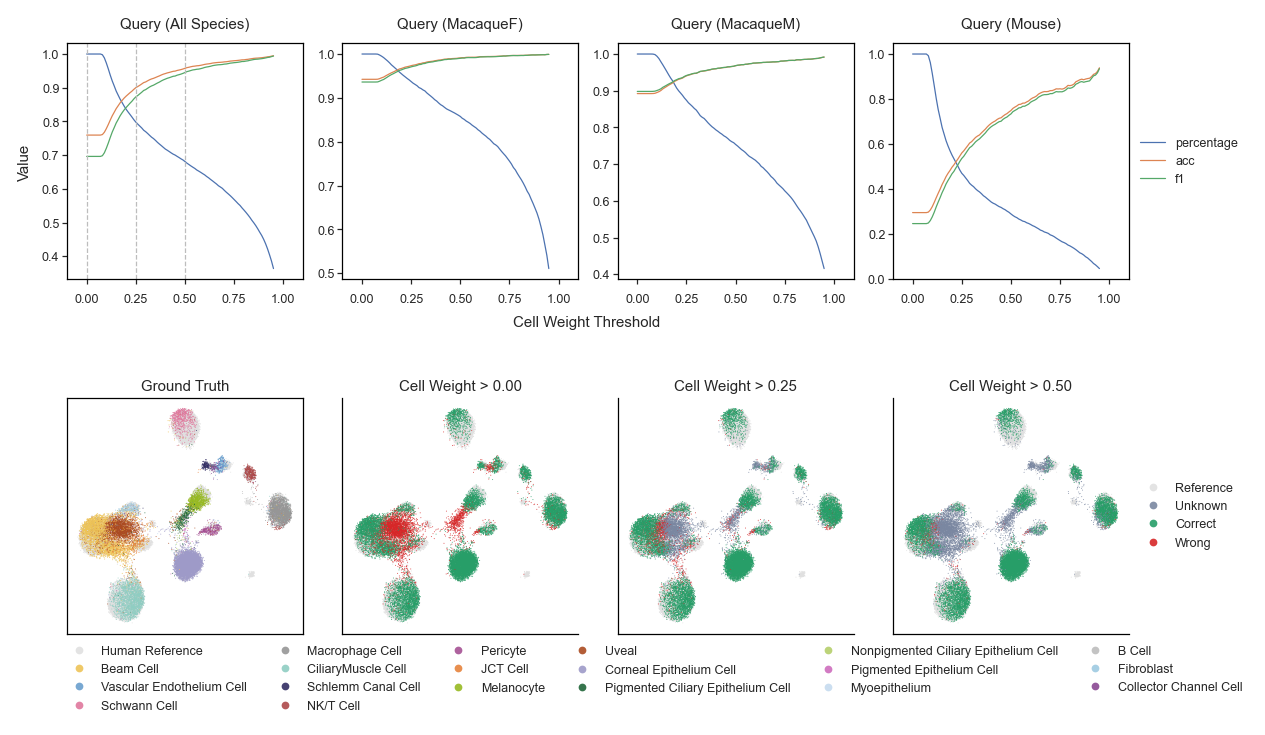

In [14]:
pd_results_labels = result.st_result['celltype'] == result.st_result['pred_celltype']
pd_results_labels = pd_results_labels.replace({False: "Wrong", True: "Correct"})
pd_results_labels[result.st_result.domain == 'source'] = 'Reference'

thres_dict = {}
pd_results_labels[result.st_result.pred_cell_prob < 0.00] = "Unknown"
thres_dict['0.00'] = pd_results_labels.copy()
pd_results_labels[result.st_result.pred_cell_prob < 0.25] = "Unknown"
thres_dict['0.25'] = pd_results_labels.copy()
pd_results_labels[result.st_result.pred_cell_prob < 0.50] = "Unknown"
thres_dict['0.50'] = pd_results_labels.copy()

position3 = [[0.03, 0.50, 0.18, 0.18 / (250/185)], [0.24, 0.50, 0.18, 0.18 / (250/185)],
             [0.45, 0.50, 0.18, 0.18 / (250/185)], [0.66, 0.50, 0.18, 0.18 / (250/185)]]
result = UnimapResult('cross_species', 'unimap/2023', root_dir='../../results', detailed=False)
umap1 = result.st_umap_result['umap1']
umap2 = result.st_umap_result['umap2']

p4= sns.scatterplot(x=umap1, y=umap2, alpha=0.9, s=0.15, hue=ct_labels,         edgecolor='none', palette=ct_c, ax=fig.add_axes(position3[0]), rasterized=True)
p5 = sns.scatterplot(x=umap1, y=umap2, alpha=0.9, s=0.15, hue=thres_dict['0.00'], edgecolor='none', palette={'Reference':'#E0E0E0', 'Correct': '#279e68', 'Wrong': '#d62728', 'Unknown': '#7a87a1'}, ax=fig.add_axes(position3[1]), rasterized=True)
p6 = sns.scatterplot(x=umap1, y=umap2, alpha=0.9, s=0.15, hue=thres_dict['0.25'], edgecolor='none', palette={'Reference':'#E0E0E0','Correct': '#279e68', 'Wrong': '#d62728', 'Unknown': '#7a87a1'}, ax=fig.add_axes(position3[2]), rasterized=True)
p7 = sns.scatterplot(x=umap1, y=umap2, alpha=0.9, s=0.15, hue=thres_dict['0.50'], edgecolor='none', palette={'Reference':'#E0E0E0','Correct': '#279e68', 'Wrong': '#d62728', 'Unknown': '#7a87a1'}, ax=fig.add_axes(position3[3]), rasterized=True)
result.remove_ticks(p4, remove_legend=True)
result.remove_ticks(p5, remove_legend=True)
result.remove_ticks(p6, remove_legend=True)
result.remove_ticks(p7)
p4.legend(loc='upper left', bbox_to_anchor=(-0.05, 0), ncol=6, fontsize=5, markerscale=8, frameon=False)
p7.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize=5, markerscale=8, frameon=False)

p5.spines['top'].set_visible(False)
p5.spines['right'].set_visible(False)
p6.spines['top'].set_visible(False)
p6.spines['right'].set_visible(False)
p7.spines['top'].set_visible(False)
p7.spines['right'].set_visible(False)

p4.set_title('Ground Truth', fontsize=6, pad=3)
p5.set_title('Cell Weight > 0.00', fontsize=6, pad=3)
p6.set_title('Cell Weight > 0.25', fontsize=6, pad=3)
p7.set_title('Cell Weight > 0.50', fontsize=6, pad=3)
fig

In [15]:
# fig.savefig('../figs/supplementary fig16.pdf', dpi=720)
# fig.savefig('../sup_figs/sup16.png', dpi=720)

### SUP12

In [16]:
eval_results = pd.read_csv('results/cross_species_eval_results.csv', index_col=0) # 修改
eval_results.index = eval_results.index.map(lambda x: x.split('/')[0])

models = ['unimap', 'harmony', 'scpoli', 'seurat', 'bbknn', 'portal', 'scgpt', 'code_mmd', 'ingest', 'scalex', 'code_adv']

index_list = ['ari', 'isolated_labels_f1', 'clisi_graph', 'isolated_labels_asw', 'nmi', 'silhouette', 'overcorrection_score', 'acc', 'ilisi_graph', 'silhouette_batch', 'kBET', 'graph_connectivity', 'average_shannons_score']  # 'f1_score', , 

index_list_bio = ['ari', 'isolated_labels_f1', 'clisi_graph', 'isolated_labels_asw', 'nmi', 'silhouette', 'overcorrection_score', 'acc']  # 'f1_score', , 'average_shannons_score'

index_list_batch = ['ilisi_graph', 'silhouette_batch', 'kBET', 'graph_connectivity']

eval_results = eval_results.reindex(models)

# ALL
eval_results = eval_results.loc[:, index_list]
eval_results_long = eval_results.melt(ignore_index=False).reset_index()
eval_results_long = eval_results_long.rename(columns={'index': 'model'})
eval_results_long['rank'] = eval_results_long.groupby('variable')['value'].rank(ascending=False)
eval_results_long_mean = eval_results_long.groupby('model').agg({'value': 'mean'}).reset_index()
eval_results_long_mean['rank'] = eval_results_long_mean['value'].rank(ascending=False)
eval_results_long_mean.index = eval_results_long_mean.model
eval_results_long_mean = eval_results_long_mean.loc[models, :]

# Bio
eval_results_bio = eval_results.loc[:, index_list_bio]
eval_results_long_bio = eval_results_bio.melt(ignore_index=False).reset_index()
eval_results_long_bio = eval_results_long_bio.rename(columns={'index': 'model'})
eval_results_long_bio['rank'] = eval_results_long_bio.groupby('variable')['value'].rank(ascending=False)
eval_results_long_mean_bio = eval_results_long_bio.groupby('model').agg({'value': 'mean'}).reset_index()
eval_results_long_mean_bio['rank'] = eval_results_long_mean_bio['value'].rank(ascending=False)
eval_results_long_mean_bio.index = eval_results_long_mean_bio.model
eval_results_long_mean_bio = eval_results_long_mean_bio.loc[models, :]

# Batch
eval_results_batch = eval_results.loc[:, index_list_batch]
eval_results_long_batch = eval_results_batch.melt(ignore_index=False).reset_index()
eval_results_long_batch = eval_results_long_batch.rename(columns={'index': 'model'})
eval_results_long_batch['rank'] = eval_results_long_batch.groupby('variable')['value'].rank(ascending=False)
eval_results_long_mean_batch = eval_results_long_batch.groupby('model').agg({'value': 'mean'}).reset_index()
eval_results_long_mean_batch['rank'] = eval_results_long_mean_batch['value'].rank(ascending=False)
eval_results_long_mean_batch.index = eval_results_long_mean_batch.model
eval_results_long_mean_batch = eval_results_long_mean_batch.loc[models, :]

In [17]:
eval_results

,ari,isolated_labels_f1,clisi_graph,isolated_labels_asw,nmi,silhouette,overcorrection_score,acc,ilisi_graph,silhouette_batch,kBET,graph_connectivity,average_shannons_score
unimap,0.685245,0.431836,0.997104,0.524796,0.701290,0.569828,0.833257,0.759494,2.800065e-01,0.918339,0.274508,0.976330,0.739390
harmony,0.713921,0.438208,0.994874,0.527395,0.785183,0.558844,0.830989,0.765222,3.828770e-01,0.932736,0.375929,0.974688,0.778266
scpoli,0.696847,0.411529,0.997077,0.589230,0.762074,0.694298,0.849555,0.745046,1.881841e-01,0.743540,0.294048,0.955352,0.726357
seurat,0.716233,0.484918,0.998782,0.550933,0.790913,0.620120,0.892767,0.775026,4.204232e-02,0.784759,0.155524,0.974923,0.789653
bbknn,0.725635,0.521453,0.999800,0.588310,0.777600,0.589751,0.936152,0.768266,1.110223e-16,0.762633,0.014303,0.989268,0.757256
portal,0.700934,0.577405,0.999768,0.613759,0.766401,0.625430,0.926588,0.743292,2.220446e-16,0.701777,0.022426,0.983529,0.760764
scgpt,0.672722,0.418800,0.997926,0.553808,0.736874,0.562847,0.868268,0.725026,7.149689e-02,0.868720,0.162451,0.977706,0.773390
code_mmd,0.599114,0.403800,0.995220,0.537879,0.682178,0.545159,0.833437,0.700877,6.163463e-02,0.843043,0.191832,0.957353,0.685631
ingest,0.436232,0.463218,0.998539,0.553347,0.600003,0.572172,0.902427,0.654386,1.784910e-02,0.860919,0.079585,0.987903,0.711558
scalex,0.497240,0.434499,0.996588,0.556083,0.631715,0.564236,0.855551,0.652374,1.346542e-02,0.713154,0.045162,0.954217,0.736090


In [18]:
cmap1 = sns.color_palette("blend:" + '#FFF6F2' + "," + '#EE7F6D', n_colors=11)
cmap2 = sns.color_palette("Oranges", 16)[::1]  
cmap3 = sns.color_palette("BuPu", 16)[::1]

def set_theme(ax, xlim, metrics_list, model_list, one_tick=False, rotation=30, ha='right', fontweight='regular', fontsize=7):
    if ax.get_legend():
        ax.get_legend().remove()
    ax.set(xlabel=None, ylabel=None)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xlim(xlim)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(len(metrics_list)))
    if one_tick != False:
        ax.set_xticks([one_tick])
    ax.set_xticklabels(metrics_list, rotation=rotation, ha=ha, fontweight=fontweight, fontsize=fontsize)
    ax.set_yticklabels(model_list, fontsize=fontsize)
    ax.tick_params(width=0.5, length=3)
    for patch in ax.patches:
        patch.set_linewidth(0.5)

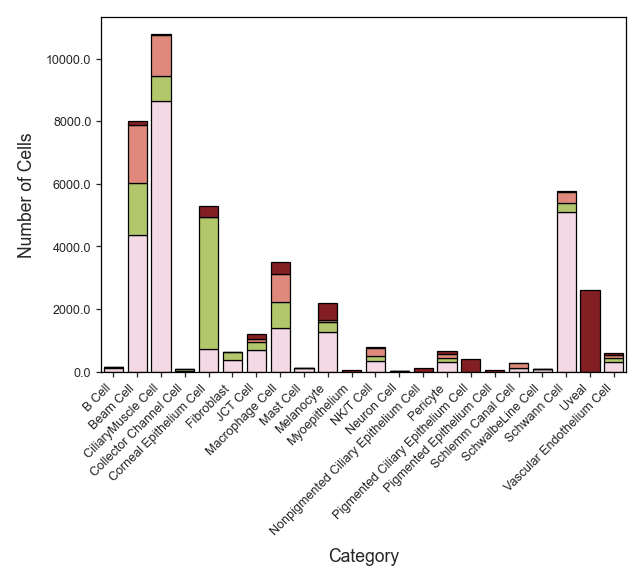

In [29]:
fig, axs = plt.subplots(figsize=(185 / 25.4, 250 / 25.4))
axs.remove()
species_list = ['human', 'macaqueF', 'macaqueM', 'mouse']
# species_color_dict = {'human': '#ff7f0e', 'macaqueF': '#1f77b4', 'macaqueM': '#2ca02c', 'mouse': '#d62728'}
ct_counts_list = []

for species in species_list:
    ct_counts_list.append(result.st_result[result.st_result['batch'] == species]['celltype'].value_counts())
ct_counts_df = pd.concat(ct_counts_list, axis=1)
ct_counts_df.fillna(0, inplace=True)
ct_counts_df.columns = species_list
ct_counts_df = ct_counts_df.sort_index()

categories = ct_counts_df.index
human_counts = ct_counts_df.human
mf_counts = ct_counts_df.macaqueF
mm_counts = ct_counts_df.macaqueM
mouse_counts = ct_counts_df.mouse
df = pd.DataFrame({
    'Categories': categories,
    'Human': human_counts,
    'MacaqueF': mf_counts,
    'MacaqueM': mm_counts,
    'Mouse': mouse_counts
})



ax1 = fig.add_axes([0.3, 0.70, 0.4, 0.2])

p1 = sns.barplot(x='Categories', y='Human', data=df, color='#F8D5E4', edgecolor='BLACK', ax=ax1, linewidth=0.5)
p1 = sns.barplot(x='Categories', y='MacaqueF', data=df, color='#BAD65D', bottom=human_counts, edgecolor='BLACK', linewidth=0.5, ax=ax1)
p1 = sns.barplot(x='Categories', y='MacaqueM', data=df, color='#EE7D6B', bottom=np.array(human_counts) + np.array(mf_counts), edgecolor='BLACK', linewidth=0.5, ax=ax1)
p1 = sns.barplot(x='Categories', y='Mouse', data=df, color='#930E14', bottom=np.array(human_counts) + np.array(mf_counts) + np.array(mm_counts), edgecolor='BLACK', linewidth=0.5, ax=ax1)

p1.set_xlabel('Category', fontsize=7)
p1.set_ylabel('Number of Cells', fontsize=7)
p1.tick_params(bottom=True, left=True, width=0.5, length=2, pad=2)
p1.set_yticklabels(p1.get_yticks(), fontsize=5)
xticks = p1.set_xticklabels(categories, rotation=45, ha='right', fontsize=5)



In [30]:
xlim = [-1, 21]
w, h = 0.64, 0.28 / (250/185)
ax1 = fig.add_axes([0.14, 0.34, w, h])

ax1 = sns.scatterplot(x="variable", y="model", hue="rank", size="value", sizes=(10, 150), alpha=1,  palette=cmap1, edgecolor='black', data=eval_results_long_bio, ax=ax1, linewidths=0.5)
set_theme(ax1, xlim=xlim, metrics_list=['ARI', 'Isolated Label F1', 'Graph cLISI', ' Label ASW', 'NMI', 'ASW', 'Over-correction score', 'Accuracy', ], model_list=['UniMap', 'Harmony', 'scPoli', 'Seurat v5', 'BBKNN', 'Portal', 'scGPT', 'CODE-MMD', 'Ingest', 'Scalex', 'CODE-ADV'])

ax2 = ax1.twiny()
ax2 = sns.barplot(x=eval_results_long_mean_bio['value'] * 2, y=models, palette=[cmap1[i] for i in eval_results_long_mean_bio['rank'].astype(int) - 1], edgecolor='black', ax=ax2, legend=True, )
ax2.axvline(x=0, linestyle='--', color='black', linewidth=0.5, dashes=(7, 3))
ax2.axvline(x=2, linestyle='--', color='black', linewidth=0.5, dashes=(7, 3))
set_theme(ax2, xlim=[i - 8 for i in xlim], metrics_list=['Biological conservation'], model_list=models, one_tick=eval_results_long_mean_bio['value'].max(), fontweight='bold')
# 字体加粗
ax2.set_yticklabels(ax2.get_yticklabels(), fontweight='bold')

ax22 = ax1.twiny()
set_theme(ax22, xlim=[i - 8 for i in xlim], metrics_list=['bio_rank'], model_list=models, one_tick=eval_results_long_mean_bio['value'].max(), rotation=0, ha='center')
ax22.set_xticks([0,1, 2])
ax22.set_xticklabels(['0', '0.5', '1'], fontsize=5)
ax22.xaxis.tick_top()

ax3 = ax1.twiny()
ax3 = sns.scatterplot(x="variable", y="model", hue="rank", size="value", sizes=(10, 150), alpha=1, palette=cmap2, edgecolor='black', data=eval_results_long_batch, ax=ax3, linewidths=0.5)
set_theme(ax3, xlim=[i - 11 for i in xlim], metrics_list=['Graph iLISI', 'Batch ASW', 'kBET', 'GC'], model_list=models)


ax4 = ax1.twiny()
ax4 = sns.barplot(x=eval_results_long_mean_batch['value'] * 2, y=models, palette=[cmap2[i] for i in eval_results_long_mean_batch['rank'].astype(int) - 1], edgecolor='black', ax=ax4, legend=True)
set_theme(ax4, xlim=[i - 15 for i in xlim], metrics_list=['Batch correction'], model_list=models, one_tick=eval_results_long_mean_batch['value'].max(), fontweight='bold')
ax4.axvline(x=0, linestyle='--', color='black', linewidth=0.5, dashes=(7, 3))
ax4.axvline(x=2, linestyle='--', color='black', linewidth=0.5, dashes=(7, 3))

ax44 = ax1.twiny()
set_theme(ax44, xlim=[i - 15 for i in xlim], metrics_list=['bio_rank'], model_list=models, one_tick=eval_results_long_mean_batch['value'].max(), rotation=0, ha='center')
ax44.set_xticks([0,1, 2])
ax44.set_xticklabels(['0', '0.5', '1'], fontsize=5)
ax44.xaxis.tick_top()

ax5 = ax1.twiny()
ax5 = sns.barplot(x=eval_results_long_mean['value'].values  * 2, y=models, palette=[cmap3[i] for i in eval_results_long_mean['rank'].astype(int) - 1], edgecolor='black', ax=ax5, legend=True)
set_theme(ax5, xlim=[i - 17.5 for i in xlim], metrics_list=['Overrall score'], model_list=models, one_tick=eval_results_long_mean['value'].max(), fontweight='bold')
ax5.axvline(x=0, linestyle='--', color='black', linewidth=0.5, dashes=(7, 3))
ax5.axvline(x=2, linestyle='--', color='black', linewidth=0.5, dashes=(7, 3))

ax55 = ax1.twiny()
set_theme(ax55, xlim=[i - 17.5 for i in xlim], metrics_list=['bio_rank'], model_list=['UniMap', 'Harmony', 'scPoli', 'Seurat v5', 'Scalex', 'scGPT', 'Portal', 'Ingest', 'BBKNN', 'CODE-MMD', 'CODE-ADV'], one_tick=eval_results_long_mean['value'].max(), rotation=0, ha='center')
ax55.set_xticks([0,1, 2])
ax55.set_xticklabels(['0', '0.5', '1'], fontsize=5)
ax55.xaxis.tick_top()

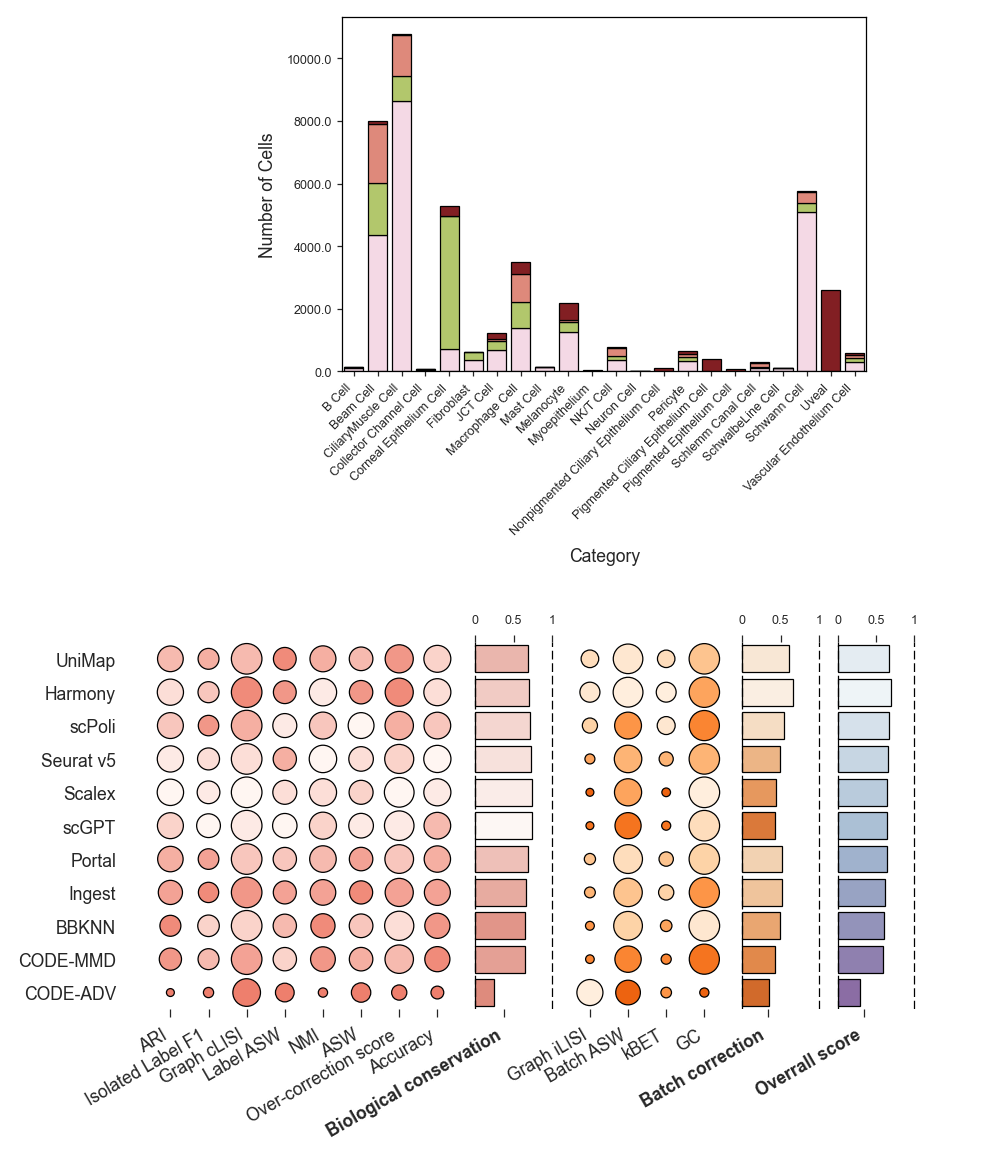

In [31]:
fig

In [21]:
# fig.savefig('../figs/supplementary fig12.pdf', dpi=720)
# fig.savefig('../sup_figs/sup12.png', dpi=720)